<font color='black'><font size="4">Notebook des différents tests de modèles -- Le plan de ce notebook (Projet 4) est le suivant:</font></font>
<font color='black'><font size="3">
* Lire les fichiers csv et les présenter sous forme des DataFrames
* Prédiction de l'emission du CO2
    * Emission du CO2 en tenant compte du Energy Star Score
    * Emission du CO2 sans tenant compte du Energy Star Score
    * Résumé en chiffres
* Consomation total d'Energie
    * Consomation total d'Energie en tenant compte du Energy Star Score
    * Consomation total d'Energie sans tenant compte du Energy Star Score
    * Résumé en chiffres
* Comparaison
* Choix du modèle et l'importance du score Energy Star
* Consclusion & perspectives
</font></font>    

In [27]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as pl
pl.rcParams.update({'font.size': 14})
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics

## A) Lire les fichiers csv et le présenter sous forme du DataFrame

In [28]:
df_encoded_with_ESS = pd.read_csv("df_encoded_with_ESS.csv",sep=",")
df_encoded_without_ESS = pd.read_csv("df_encoded_without_ESS.csv",sep=",")

## B) Emission CO2

<font color='darkblue'><font size="3">
Dans cette section nous allons comparer plusieurs algorithmes de régression pour prédire l'émission de gaz CO2.
    
Nous utiliserons, comme baseline, **dummy regressor**, ensuite nous utiliserons **linear regression**, **RandomForest**, **SVR** et **XGBoost**.
    
Chaque algorithme (sauf le baseline) est utilisé dans une pipeline avec `StandardScaler()`.\
Et chacune de ces pipelines (sauf linear regression) est utilisé avec `GridSearchCV` pour paramétrer les hyperparamètres avec cross validation.
    
Ce processus est réalisé pour les deux dataframes (avec et sans Energy Star Score noté ESS).
    
Lors de chaque algorithmes, nous calculons le coefficient de determination--R2, Root Mean Squared Error--RMSE et le temps de calcul de cet algorithme, puis nous l'affichons avec les meilleurs hyperparamètres choisis.   
    
Ces algorithmes sont re-utilisé dans la prochaine section -- Consomation total d'Energie, avec des dataframes différentes.
</font></font>

In [29]:
from sklearn.dummy import DummyRegressor
DR = DummyRegressor(strategy="mean")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(criterion='mse')
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf')
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0, max_depth = 6) 

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
pipe_SL = make_pipeline(scaler, linreg)

pipe_RF = Pipeline([('scaler', scaler), ('rf', rf)])
pipe_SVR = Pipeline([('scaler',scaler), ('svr',svr)])
pipe_XGB = Pipeline([('scaler',scaler), ('xgbr',xgbr)])

In [31]:
from sklearn.model_selection import GridSearchCV


## creation du gridsearch pour randomforest
param_grid_RF = {'rf__max_depth': [100,200],'rf__max_features': ['auto', 'sqrt'],'rf__n_estimators': [150, 1000]}
Grid_RF = GridSearchCV(estimator = pipe_RF, param_grid = param_grid_RF, cv=5, return_train_score=True)

## creation du gridsearch pour SVR 
param_grid_SVR = {'svr__C': [1, 100, 1000],'svr__epsilon': [0.0001, 0.005],'svr__gamma': [0.005, 0.1]}
Grid_SVR = GridSearchCV(estimator = pipe_SVR, param_grid=param_grid_SVR, cv=5,return_train_score=True)

## creation du gridsearch pour XGBoost
param_grid_XGB = {'xgbr__n_estimators': [150, 1000],'xgbr__learning_rate': [0.03, 0.07, 0.5], 'xgbr__max_depth': [100,200]}
Grid_XGB = GridSearchCV(estimator = pipe_XGB, param_grid=param_grid_XGB, cv=5,return_train_score=True)

### B-1) Emission CO2 en tenant compte Energy Star Score

In [32]:
## X_train y_train pour le dataframe avec EnergyStar Score
X_with_ESS =  df_encoded_with_ESS.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y_with_ESS = df_encoded_with_ESS['TotalGHGEmissions']

## diviser X en X_train et X_test, et y en y_train et y_test
X_train_ESS, X_test_ESS , y_train_ESS, y_test_ESS = train_test_split(X_with_ESS, y_with_ESS, test_size=0.3, random_state=42)


In [33]:
## dummy regressor
start_time = time.time()
DR.fit(X_train_ESS, y_train_ESS)
y_pred_ESS = DR.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

RMSE = 1.389 et R2 = -0.347%


In [34]:
## Linear regression
start_time = time.time()

print("Le score du cross validation: {}".format(cross_val_score(pipe_SL, X_train_ESS, y_train_ESS, cv=5).mean()))
pipe_SL.fit(X_train_ESS, y_train_ESS)
y_pred_ESS = pipe_SL.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} seconds ".format(np.round(time.time() - start_time,4))) 
CO2_L = [RMSE, 100*R2,np.round(time.time() - start_time,4)] ## liste[RMSE, R2%, temps]

Le score du cross validation: 0.1419403799168886
RMSE = 0.969 et R2 = 51.112%

Time = 0.1042 seconds 


In [35]:
## RandomForest
start_time = time.time()

Grid_RF.fit(X_train_ESS,y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_RF.best_params_))
print("Best Test Score: \n{}\n".format(Grid_RF.best_score_))
y_pred_ESS = Grid_RF.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_RF = [RMSE, 100*R2,np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'rf__max_depth': 200, 'rf__max_features': 'auto', 'rf__n_estimators': 1000}

Best Test Score: 
0.9419760721531091

RMSE = 0.266 et R2 = 96.313%

Time = 4.926361666666667 minutes 


In [36]:
## SVR
start_time = time.time()

Grid_SVR.fit(X_train_ESS,y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_SVR.best_params_))
print("Best Test Score: \n{}\n".format(Grid_SVR.best_score_))
y_pred_ESS = Grid_SVR.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_SVR = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'svr__C': 100, 'svr__epsilon': 0.005, 'svr__gamma': 0.1}

Best Test Score: 
0.7843405674588713

RMSE = 0.541 et R2 = 84.763%

Time = 2.832898333333333 minutes 


In [37]:
## XGBoost
start_time = time.time()

X_train_ESS = np.ascontiguousarray(X_train_ESS)
y_train_ESS = np.ascontiguousarray(y_train_ESS)

Grid_XGB.fit(X_train_ESS,y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_XGB.best_params_))
print("Best Test Score: \n{}\n".format(Grid_XGB.best_score_))
y_pred_ESS = Grid_XGB.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_XGB = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'xgbr__learning_rate': 0.07, 'xgbr__max_depth': 100, 'xgbr__n_estimators': 1000}

Best Test Score: 
0.9486170740806849

RMSE = 0.252 et R2 = 96.703%

Time = 1.3974183333333334 minutes 


C:\Users\Rouba\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [38]:
print(xgbr.objective)

reg:squarederror


### B-2) Emission CO2 sans tenant compte Energy Star Score

In [39]:
## X_train y_train pour le dataframe sans EnergyStar Score
X =  df_encoded_without_ESS.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df_encoded_without_ESS['TotalGHGEmissions']

## diviser X en X_train et X_test, et y en y_train et y_test
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
## dummy regressor
start_time = time.time()
DR.fit(X_train, y_train)
y_pred = DR.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

RMSE = 1.389 et R2 = -0.347%


In [41]:
start_time = time.time()

print("Le score du cross validation: {}".format(cross_val_score(pipe_SL, X_train, y_train, cv=10).mean()))
pipe_SL.fit(X_train, y_train)
y_pred = pipe_SL.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} seconds ".format(np.round(time.time() - start_time,4))) 
CO2_L_withoutESS = [RMSE, 100*R2,np.round(time.time() - start_time,4)] ## liste[RMSE, R2%, temps]

Le score du cross validation: 0.3977955584196722
RMSE = 0.98 et R2 = 50.046%

Time = 0.1369 seconds 


In [42]:
## RandomForest
start_time = time.time()

Grid_RF.fit(X_train,y_train)
print("Best Parameters: \n{}\n".format(Grid_RF.best_params_))
y_pred = Grid_RF.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_RF_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'rf__max_depth': 100, 'rf__max_features': 'auto', 'rf__n_estimators': 1000}

RMSE = 0.263 et R2 = 96.393%

Time = 1.8752 minutes 


In [43]:
## SVR
start_time = time.time()

Grid_SVR.fit(X_train,y_train)
print("Best Parameters: \n{}\n".format(Grid_SVR.best_params_))
y_pred = Grid_SVR.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_SVR_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'svr__C': 100, 'svr__epsilon': 0.005, 'svr__gamma': 0.1}

RMSE = 0.564 et R2 = 83.425%

Time = 1.144725 minutes 


In [44]:
## XGBoost
start_time = time.time()
X_train = np.ascontiguousarray(X_train)
y_train = np.ascontiguousarray(y_train)

Grid_XGB.fit(X_train,y_train)
print("Best Parameters: \n{}\n".format(Grid_XGB.best_params_))
y_pred = Grid_XGB.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
CO2_XGB_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'xgbr__learning_rate': 0.07, 'xgbr__max_depth': 100, 'xgbr__n_estimators': 1000}

RMSE = 0.251 et R2 = 96.714%

Time = 1.417805 minutes 


C:\Users\Rouba\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [45]:
print(xgbr.objective)

reg:squarederror


### B-3) Résumé en chiffres d'émission CO2

In [46]:
EmissionCO2_with_ESS = pd.DataFrame(data=[CO2_L, CO2_RF, CO2_SVR, CO2_XGB],
             columns=['RMSE', 'R2(%)', 'Duration(s)'],
             index=['Linear regression', 'RandomForest', 'SVR', 'XGB'])

EmissionCO2_without_ESS = pd.DataFrame(data=[CO2_L_withoutESS, CO2_RF_withoutESS, CO2_SVR_withoutESS, CO2_XGB_withoutESS],
             columns=['RMSE', 'R2(%)', 'Duration(s)'],
             index=['Linear regresion', 'RandomForest', 'SVR', 'XGB'])

In [47]:
EmissionCO2_with_ESS

,RMSE,R2(%),Duration(s)
Linear regression,0.969350,51.111873,0.104200
RandomForest,0.266196,96.313248,4.926362
SVR,0.541157,84.763380,2.832898
XGB,0.251717,96.703385,1.397418


In [48]:
EmissionCO2_without_ESS

,RMSE,R2(%),Duration(s)
Linear regresion,0.979858,50.046248,0.136900
RandomForest,0.263301,96.392979,1.875200
SVR,0.564418,83.425369,1.144725
XGB,0.251312,96.713989,1.417805


## C) Consomation total d'Energie

### C-1) Consomation total d'Energie en tenant compte du Energy Star Score

In [49]:
## X_train y_train pour le dataframe avec EnergyStar Score
X_with_ESS =  df_encoded_with_ESS.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y_with_ESS = df_encoded_with_ESS['SiteEnergyUse(kBtu)']

## diviser X en X_train et X_test, et y en y_train et y_test
X_train_ESS, X_test_ESS , y_train_ESS, y_test_ESS = train_test_split(X_with_ESS, y_with_ESS, test_size=0.3, random_state=41)


In [50]:
## dummy regressor
start_time = time.time()
DR.fit(X_train_ESS, y_train_ESS)
y_pred_ESS = DR.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

RMSE = 1.219 et R2 = -0.105%


In [51]:
## Linear regression
start_time = time.time()

print("Le score du cross validation: {}".format(cross_val_score(pipe_SL, X_train_ESS, y_train_ESS, cv=10).mean()))
pipe_SL.fit(X_train_ESS, y_train_ESS)
y_pred_ESS = pipe_SL.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} seconds ".format(np.round(time.time() - start_time,4))) 
Energy_L = [RMSE, 100*R2,np.round(time.time() - start_time,4)] ## liste[RMSE, R2%, temps]

Le score du cross validation: 0.6562951295727354
RMSE = 0.818 et R2 = 54.987%

Time = 0.1374 seconds 


In [52]:
## RandomForest
start_time = time.time()

Grid_RF.fit(X_train_ESS,y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_RF.best_params_))
y_pred_ESS = Grid_RF.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_RF = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'rf__max_depth': 100, 'rf__max_features': 'auto', 'rf__n_estimators': 1000}

RMSE = 0.533 et R2 = 80.892%

Time = 2.0247333333333333 minutes 


In [53]:
start_time = time.time()

Grid_SVR.fit(X_train_ESS,y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_SVR.best_params_))
y_pred_ESS = Grid_SVR.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_SVR = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'svr__C': 100, 'svr__epsilon': 0.005, 'svr__gamma': 0.005}

RMSE = 0.636 et R2 = 72.743%

Time = 2.75447 minutes 


In [54]:
## XGBoost
start_time = time.time()
X_train_ESS = np.ascontiguousarray(X_train_ESS)
y_train_ESS = np.ascontiguousarray(y_train_ESS)

Grid_XGB.fit(X_train_ESS, y_train_ESS)
print("Best Parameters: \n{}\n".format(Grid_XGB.best_params_))
y_pred_ESS = Grid_XGB.predict(X_test_ESS)
RMSE = np.sqrt(metrics.mean_squared_error(y_test_ESS, y_pred_ESS))
R2 = metrics.r2_score(y_test_ESS, y_pred_ESS)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_XGB = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'xgbr__learning_rate': 0.03, 'xgbr__max_depth': 100, 'xgbr__n_estimators': 1000}

RMSE = 0.561 et R2 = 78.786%

Time = 1.4440633333333333 minutes 


C:\Users\Rouba\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [55]:
print(xgbr.objective)

reg:squarederror


### C-2)  Consomation total d'Energie sans tenant compte du Energy Star Score

In [56]:
## X_train y_train pour le dataframe sans EnergyStar Score
X =  df_encoded_without_ESS.drop(columns=['TotalGHGEmissions','SiteEnergyUse(kBtu)'])
y = df_encoded_without_ESS['SiteEnergyUse(kBtu)']

## diviser X en X_train et X_test, et y en y_train et y_test
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

In [57]:
## dummy regressor
start_time = time.time()
DR.fit(X_train, y_train)
y_pred = DR.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

RMSE = 1.257 et R2 = -0.016%


In [58]:
start_time = time.time()

print("Le score du cross validation: {}".format(cross_val_score(pipe_SL, X_train, y_train, cv=10).mean()))
pipe_SL.fit(X_train, y_train)
y_pred = pipe_SL.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} seconds ".format(np.round(time.time() - start_time,4))) 
Energy_L_withoutESS = [RMSE, 100*R2,np.round(time.time() - start_time,4)] ## liste[RMSE, R2%, temps]

Le score du cross validation: 0.6328870739320414
RMSE = 0.99 et R2 = 37.967%

Time = 0.1395 seconds 


In [59]:
## RandomForest
start_time = time.time()

Grid_RF.fit(X_train, y_train)
print("Best Parameters: \n{}\n".format(Grid_RF.best_params_))
y_pred = Grid_RF.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_RF_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'rf__max_depth': 200, 'rf__max_features': 'auto', 'rf__n_estimators': 150}

RMSE = 0.551 et R2 = 80.744%

Time = 1.9595483333333334 minutes 


In [60]:
start_time = time.time()

Grid_SVR.fit(X_train, y_train)
print("Best Parameters: \n{}\n".format(Grid_SVR.best_params_))
y_pred = Grid_SVR.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_SVR_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'svr__C': 1, 'svr__epsilon': 0.005, 'svr__gamma': 0.1}

RMSE = 0.624 et R2 = 75.368%

Time = 1.8037316666666667 minutes 


In [61]:
## XGBoost
start_time = time.time()

X_train = np.ascontiguousarray(X_train)
y_train = np.ascontiguousarray(y_train)

Grid_XGB.fit(X_train, y_train)
print("Best Parameters: \n{}\n".format(Grid_XGB.best_params_))
y_pred = Grid_XGB.predict(X_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
R2 = metrics.r2_score(y_test, y_pred)

print("RMSE = {} et R2 = {}%".format(np.round(RMSE,3),np.round(R2*100,3))) 

print("\nTime = {} minutes ".format(np.round(time.time() - start_time,4)/60.)) 
Energy_XGB_withoutESS = [RMSE, 100*R2, np.round(time.time() - start_time,4)/60.] ## liste[RMSE, R2%, temps]

Best Parameters: 
{'xgbr__learning_rate': 0.03, 'xgbr__max_depth': 100, 'xgbr__n_estimators': 1000}

RMSE = 0.551 et R2 = 80.792%

Time = 1.47345 minutes 


C:\Users\Rouba\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [62]:
print(xgbr.objective)

reg:squarederror


### C-3) Résumé en chiffres du consomation total d'Energie

In [63]:
Energy_with_ESS = pd.DataFrame(data=[Energy_L, Energy_RF, Energy_SVR, Energy_XGB],
             columns=['RMSE', 'R2(%)', 'Duration(s)'],
             index=['Linear regression', 'RandomForest', 'SVR', 'XGB'])

Energy_without_ESS = pd.DataFrame(data=[Energy_L_withoutESS, Energy_RF_withoutESS, Energy_SVR_withoutESS, Energy_XGB_withoutESS],
             columns=['RMSE', 'R2(%)', 'Duration(s)'],
             index=['Linear regresion', 'RandomForest', 'SVR', 'XGB'])

In [64]:
Energy_with_ESS

,RMSE,R2(%),Duration(s)
Linear regression,0.817636,54.987414,0.137400
RandomForest,0.532727,80.891599,2.024733
SVR,0.636259,72.742733,2.754470
XGB,0.561314,78.785820,1.444063


In [65]:
Energy_without_ESS

,RMSE,R2(%),Duration(s)
Linear regresion,0.989733,37.966538,0.141200
RandomForest,0.551430,80.743802,1.959548
SVR,0.623670,75.367956,1.803732
XGB,0.550745,80.791571,1.473450


## D) Comparaison 

In [66]:
label1 = np.array(["CO2","Energy"])
label2 = np.array(["RMSE","R2(%)","Duration(s)"])
label3 = np.array(["ESS","without ESS"])
cols = pd.MultiIndex.from_product([label1, label2, label3])
final = pd.DataFrame(columns = Energy_with_ESS.index,index=cols)
liste = ['RMSE','R2(%)','Duration(s)']
for i in liste:
    final.loc['CO2',i] = EmissionCO2_with_ESS[i], EmissionCO2_without_ESS[i]
    final.loc['Energy',i] = Energy_with_ESS[i], Energy_without_ESS[i]


C:\Users\Rouba\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2866: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [67]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th{
    border: 1px black solid !important;
    color: black solide !important;
}
</style>

In [68]:
final

Linear regression RandomForest       SVR  \
CO2    RMSE        ESS                   0.96935     0.266196  0.541157   
                   without ESS          0.979858     0.263301  0.564418   
       R2(%)       ESS                   51.1119      96.3132   84.7634   
                   without ESS           50.0462       96.393   83.4254   
       Duration(s) ESS                    0.1042      4.92636    2.8329   
                   without ESS            0.1369       1.8752   1.14472   
Energy RMSE        ESS                  0.817636     0.532727  0.636259   
                   without ESS          0.989733      0.55143   0.62367   
       R2(%)       ESS                   54.9874      80.8916   72.7427   
                   without ESS           37.9665      80.7438    75.368   
       Duration(s) ESS                    0.1374      2.02473   2.75447   
                   without ESS            0.1412      1.95955   1.80373   

                                     XGB  
CO2    RMSE        ESS          0.251717  
                   without ESS  0.251312  
       R2(%)       ESS           96.7034  
                   without ESS    96.714  
       Duration(s) ESS           1.39742  
                   without ESS    1.4178  
Energy RMSE        ESS          0.561314  
                   without ESS  0.550745  
       R2(%)       ESS           78.7858  
                   without ESS   80.7916  
       Duration(s) ESS           1.44406  
                   without ESS   1.47345

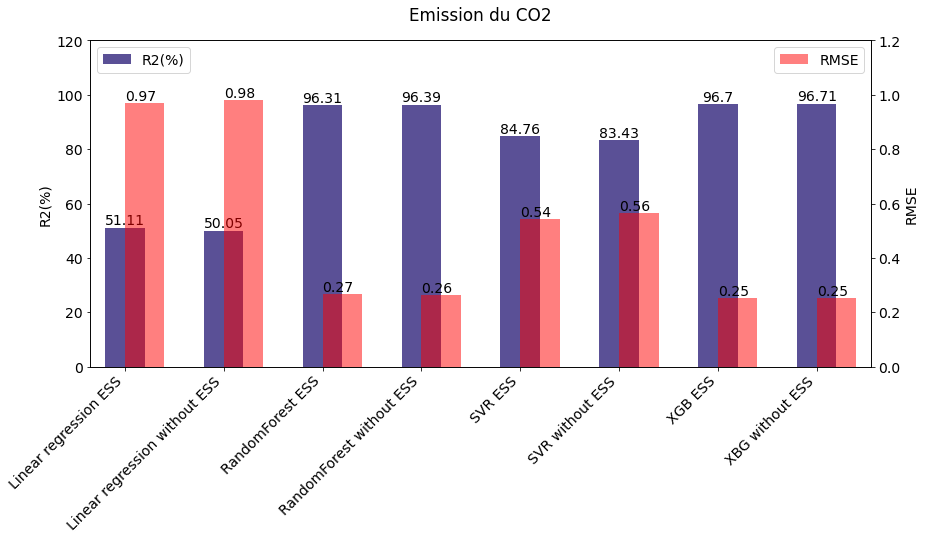

In [69]:
### Comparaison CO2 emission with and without ESS
pl.figure(figsize=(14,6))
ax1 = pl.subplot(111)
ax1.margins(0.02, 0.1) 
ax1.set_ylabel('R2(%)')
x1, x2 = np.arange(0,8,2), np.arange(1,8, 2)

labels = ['Linear regression ESS','Linear regression without ESS', 'RandomForest ESS','RandomForest without ESS','SVR ESS','SVR without ESS','XGB ESS','XBG without ESS']
pl.xticks(np.arange(0,10,1),labels,rotation=45,ha='right')
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE')

ax1.bar(x1, final.loc['CO2','R2(%)','ESS'], width = 0.4, alpha= 0.9, color ='darkslateblue', align = 'center')
ax2.bar(x1, final.loc['CO2','RMSE','ESS'], width = 0.4, alpha = 0.5, color='r', align = 'edge')
ax1.bar(x2, final.loc['CO2','R2(%)','without ESS'], width = 0.4, alpha= 0.9, color ='darkslateblue', align = 'center')
ax2.bar(x2, final.loc['CO2','RMSE','without ESS'], width = 0.4, alpha = 0.5, color='r', align = 'edge')
ax1.set_ylim(0,120)
ax2.set_ylim(0,1.2)

ax1.legend(['R2(%)'], loc = 'upper left')
ax2.legend(['RMSE'], loc = 'upper right')
pl.title('Emission du CO2', pad=20)

total_LR = len(final.loc['CO2','R2(%)','ESS'])
for p in np.arange(0,len(final.loc['CO2','R2(%)','ESS'])):
    ax1.annotate(str(np.round(final.loc['CO2','R2(%)','ESS'][p],2)), xy=(x1[p],final.loc['CO2','R2(%)','ESS'][p]), ha='center', va='bottom')
    ax2.annotate(str(np.round(final.loc['CO2','RMSE','ESS'][p],2)), xy=(x1[p],final.loc['CO2','RMSE','ESS'][p]), ha='left', va='bottom')
    ax1.annotate(str(np.round(final.loc['CO2','R2(%)','without ESS'][p],2)), xy=(x2[p],final.loc['CO2','R2(%)','without ESS'][p]), ha='center', va='bottom')
    ax2.annotate(str(np.round(final.loc['CO2','RMSE','without ESS'][p],2)), xy=(x2[p],final.loc['CO2','RMSE','without ESS'][p]), ha='left', va='bottom')
    
pl.show()

<font color='darkblue'><font size="3">
Ce graphique représente les performances des différents modèles de prédiction des émissions de CO2.
Sur l'axe des x, nous trouvons les différents modèles (avec et sans ESS), l'axe des y à gauche représente les valeurs R2 en % présentées par des barres violettes, et à droite nous avons le RMSE présenté par des barres rose clair.
    
Commençons par la différence entre "avec" et "sans" ESS, il n'y a pas une grande différence entre les valeurs du même modèle (une légère différence).    

Maintenant pour l'évaluation des différents modèles, nous recherchons un R2 maximal et un RMSE minimal.
    
La régression linéaire n'est pas un modèle performant.
</font></font>

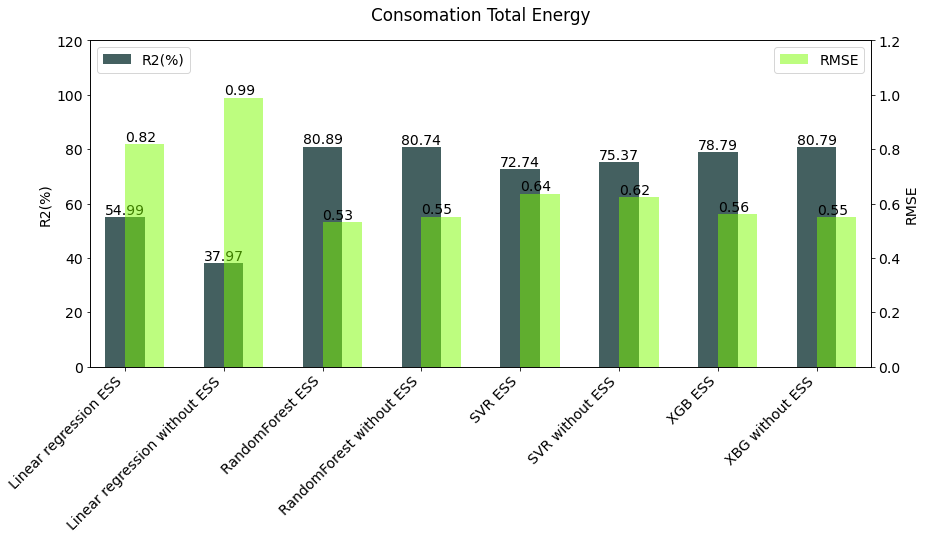

In [70]:
### Comparaison CO2 emission with and without ESS
pl.figure(figsize=(14,6))
ax1 = pl.subplot(111)
ax1.margins(0.02, 0.1) 
ax1.set_ylabel('R2(%)')
x1, x2 = np.arange(0,8,2), np.arange(1,8, 2)

labels = ['Linear regression ESS','Linear regression without ESS', 'RandomForest ESS','RandomForest without ESS','SVR ESS','SVR without ESS','XGB ESS','XBG without ESS']
pl.xticks(np.arange(0,10,1),labels,rotation=45,ha='right')
ax2 = ax1.twinx()
ax2.set_ylabel('RMSE')

ax1.bar(x1, final.loc['Energy','R2(%)','ESS'], width = 0.4, alpha= 0.9, color ='darkslategrey', align = 'center')
ax2.bar(x1, final.loc['Energy','RMSE','ESS'], width = 0.4, alpha = 0.5, color='lawngreen', align = 'edge')
ax1.bar(x2, final.loc['Energy','R2(%)','without ESS'], width = 0.4, alpha= 0.9, color ='darkslategrey', align = 'center')
ax2.bar(x2, final.loc['Energy','RMSE','without ESS'], width = 0.4, alpha = 0.5, color='lawngreen', align = 'edge')
ax1.set_ylim(0,120)
ax2.set_ylim(0,1.2)

ax1.legend(['R2(%)'], loc = 'upper left')
ax2.legend(['RMSE'], loc = 'upper right')
pl.title('Consomation Total Energy', pad=20)

total_LR = len(final.loc['Energy','R2(%)','ESS'])
for p in np.arange(0,len(final.loc['Energy','R2(%)','ESS'])):
    ax1.annotate(str(np.round(final.loc['Energy','R2(%)','ESS'][p],2)), xy=(x1[p],final.loc['Energy','R2(%)','ESS'][p]), ha='center', va='bottom')
    ax2.annotate(str(np.round(final.loc['Energy','RMSE','ESS'][p],2)), xy=(x1[p],final.loc['Energy','RMSE','ESS'][p]), ha='left', va='bottom')
    ax1.annotate(str(np.round(final.loc['Energy','R2(%)','without ESS'][p],2)), xy=(x2[p],final.loc['Energy','R2(%)','without ESS'][p]), ha='center', va='bottom')
    ax2.annotate(str(np.round(final.loc['Energy','RMSE','without ESS'][p],2)), xy=(x2[p],final.loc['Energy','RMSE','without ESS'][p]), ha='left', va='bottom')
    
pl.show()

<font color='darkblue'><font size="3">
Ce graphique représente les performances des différents modèles de prédiction de la consommation d'énergie total.
Sur l'axe des x, nous trouvons les différents modèles (avec et sans ESS), l'axe des y à gauche représente les valeurs R2 en % présentées par des barres vert foncé, et à droite nous avons le RMSE présenté par des barres vert clair.
    
Commençons par la différence entre "avec" et "sans" ESS, on trouve une différence remarquable surtout dans le cas du modèle du linear regression.    

Maintenant pour l'évaluation des différents modèles, nous recherchons un R2 maximal et un RMSE minimal.
La régression linéaire n'est pas un modèle performant.
</font></font>

## E) Choix du modèle et l'importance du score Energy Star

<font color='darkblue'><font size="3">
En comparant les deux graphiques précédents, nous pouvons facilement remarquer que tous les algorithmes maintiennent de bons résultats entre l'inclusion et l'exclusion de l'ESS (avec une légère différence), à l'exception de la régression linéaire dans la consommation d'energie qui montre une différence remarquable.
</font></font>

<font color='darkblue'><font size="3">
Certains algorithmes ont des résultats similaires de R2 et RMSE.\
Dans l'émission de CO2 : RandomForest et XGBoost ont des valeurs très proches et le SVR a aussi de bons résultats.\
Dans la consommation d'energie : RandomForest, XGBoost et SVR ont des valeurs proches.
    
Notre dernier choix sera donc basé sur le temps de calcul de RandomForest, SVR et XGBoost.
</font></font>

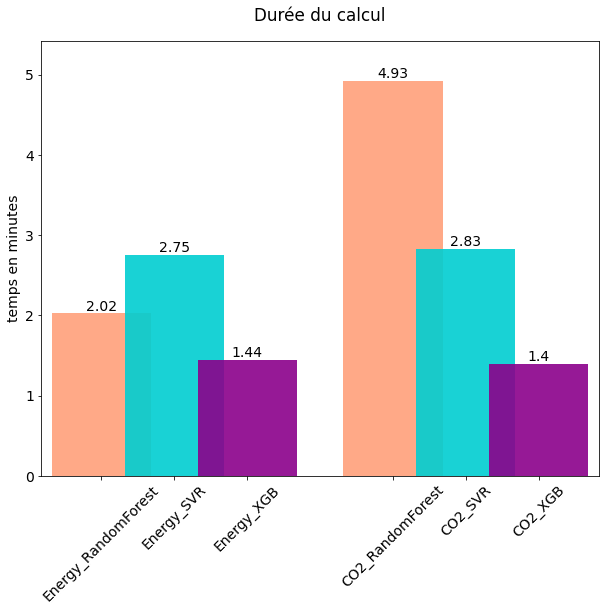

In [71]:
pl.figure(figsize=(10,8))
ax = pl.subplot(111)
ax.margins(0.02, 0.1) 
ax.set_ylabel('temps en minutes')

labels = {'RandomForest':'lightsalmon' ,'SVR': 'darkturquoise','XGB': 'darkmagenta'}
pos = {'RandomForest':0 ,'SVR': 0.25,'XGB': 0.5}
labels2 = {'Energy':1,'CO2':2}

ticks = [[],[]]
for i in labels2:
    for j in pos : 
        ax.bar(labels2[i]+pos[j], final.loc[i,'Duration(s)','ESS'][j], color = labels[j], width = 0.34, alpha = 0.9, align = 'center')
        ax.annotate(str(np.round(final.loc[i,'Duration(s)','ESS'][j],2)), xy=(labels2[i]+pos[j],final.loc[i,'Duration(s)','ESS'][j]), ha='center', va='bottom')
        ticks[1].append(i+"_"+j), ticks[0].append(labels2[i]+pos[j])

pl.xticks(ticks[0],ticks[1], rotation=45)

pl.title('Durée du calcul', pad=20) 
pl.show()

<font color='darkblue'><font size="3">
Nous remarquons que le temps de calcul du XGBoost, tant pour l'**émission de CO2** que pour la **consommation d'énergie**, est inférieur à celui des deux autres algorithmes. Donc le meilleur choix est le **XGBoost**.
</font></font>

## Consclusion & perspectives

<font color='black'><font size="3">
* Nous avons testé plusieurs algorithmes pour prédire l'émission du CO2 et la consommation d'énergie avec et sans le score Energy Star.
* Les algorithmes proposé maintiennent de bons résultats entre l'inclusion et l'exclusion de l'ESS (avec une légère différence).
* Les algorithmes suggérés ont de bons résultats, pas de overfit ou underfit.
* Les hyperparamètres de `GridhSearchCV` sont choisis à grande échelle. Ainsi, pour l'étape suivante, nous pouvons réduire cette échelle une fois que nous avons choisi la meilleure méthode de régression. 
</font></font>